# Lab 04 : Numerical Integration

## Objectives

In this lab we will study the extremely powerful integration routine provided for us in `scipy.integrate.quad`.  Despite being extremely powerful, we can make it even better by performing mathematical transformations of the integrals we wish to evaluate.   **This lab is an extension of the analytic work performed in Homework 04, Problem 1 and relies on some of those results.**

We will study the simple pendulum.  Despite being "simple", recall from introductory physics that we can only solve for the motion of small amplitude oscillations.   Here we will study the full motion of the pendulum.

## Initialization

You can mostly just run the following and ignore the details.  This is some magic required to get equation numbering and referencing working (another of the many great features of $\LaTeX$).  **You need to run this cell to get equations numbered and labels to work.**  You also need to rerun this cell anytime you need to rerender the numbered equations found below.  It shows how other languages can be included in a Jupyter notebook.  In this case it is javascript, but C, FORTRAN, and many other languages could be included in a similar manner.

In [19]:
%%javascript
// Turn on automatic equations numbers and allow for equation labeling and referencing.
MathJax.Hub.Config({
  TeX: { equationNumbers: { autoNumber: "AMS" } }
});
// The following reprocesses/renumbers the equations when executed.  When cells with numbered equations are reprocessed
// the equation number keeps incrementing.  When numbered equations have labels an error occurs and the equation does not
// actually get rendered.  Rerun this cell to reset the equation numbers and render all the equations in the document.
MathJax.Hub.Queue(
    ["resetEquationNumbers",MathJax.InputJax.TeX],
    ["PreProcess",MathJax.Hub], 
    ["Reprocess",MathJax.Hub]
);

<IPython.core.display.Javascript object>

As always initialize, your environment now by loading all modules required and setting up the plotting environment. 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integ
import scipy.special as sf


## Pendulum Motion

As seen in the homework, the period of the oscillations of a pendulum can be written in a few equivalent forms:

\begin{align}
\frac{T(\theta_m)}{T_0} & = \frac{\sqrt 2}{\pi} \int_0^{\theta_m} \frac{\mathrm{d}\theta}{\sqrt{\cos\theta-\cos\theta_m}}, \label {eq:period1} \\
 & = \frac{2}{\pi} \int_0^{\pi/2} \frac{\mathrm{d}\psi}{\sqrt{1-\sin^2(\theta_m/2)\sin^2\psi}}, \label {eq:period2} \\
 & = 1 + \sum_{n=1}^\infty a_{2n} \sin^{2n}(\theta_m/2). \label {eq:periodsum}
\end{align}
For the series form, you have calculated the values of the coefficients up to $a_8$.  We will explore all of these forms in this lab.

### Period Calculations

Calculate the period using the three expressions above for $\theta_m$ on a grid from 1 to 179 degrees in steps of 1 degree.  For the two integrals $(\ref{eq:period1})$ and $(\ref{eq:period2})$ we cannot avoid writing a loop since `quad` cannot compute many integrals at once.  (In the future we will learn that there is a way to get NumPy to create the loop for us so that we do not need to explicitly write it ourselves.)  For the series $(\ref{eq:periodsum})$ we *could* avoid writing a loop, but we have not learned how and since we already need to write one loop we may as well use it for this case also.  As seen in the example this week, when we do need to write our own loops it is best to preallocate storage space for the results using `np.zeros` or `np.zeros_like`.

Also produce a figure showing the period calculated from the three methods as a function of the pendulum amplitude.

Text(0.5, 1.0, 'Comparision of Integration Methods to find the Period')

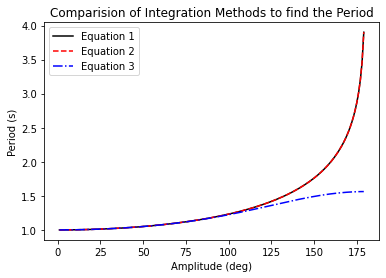

In [12]:
theta_m= np.arange(1., 180., 1)
theta_m= np.radians(theta_m) 

def eq1(theta, theta_m):
    return 1/(np.sqrt(np.cos(theta)- np.cos(theta_m)))

def eq2(psi, theta_m):
    return 1/(np.sqrt(1- (np.sin(theta_m/2))**2*(np.sin(psi))**2))

def integ1(theta_m):
    return (np.sqrt(2)/np.pi) * integ.quad(eq1, 0, theta_m, args=(theta_m))[0]

def integ2(theta_m):
    return (2/np.pi) * integ.quad(eq2, 0, np.pi/2, args=(theta_m))[0]

eq1ans= np.zeros_like(theta_m)
for j in range(len(theta_m)):
    eq1ans[j] = integ1(theta_m[j])
    
eq2ans= np.zeros_like(theta_m)
for j in range(len(theta_m)):
    eq2ans[j]= integ2(theta_m[j])
    
a= np.array([0.25, 0.140625, 0.09765625, 0.07476806640625])
n= np.arange(1, 5, 1)

def eq3(a, n, theta_m):
    return 1+ np.sum(a*(np.sin(theta_m/2))**(2*n))

eq3ans= np.zeros_like(theta_m)
for j in range(len(theta_m)):
    eq3ans[j]= eq3(a, n, theta_m[j])

plt.plot(np.degrees(theta_m), eq1ans, 'k', label='Equation 1')
plt.plot(np.degrees(theta_m), eq2ans, 'r--', label='Equation 2')
plt.plot(np.degrees(theta_m), eq3ans, 'b-.', label= 'Equation 3')
plt.legend()
plt.xlabel('Amplitude (deg)')
plt.ylabel('Period (s)')
plt.title('Comparision of Integration Methods to find the Period')


### Error in the Integrals

You should find that the two integrals agree with each other, but that the series does not agree with the intrals for large amplitudes.  We will look at the series in more detail below.  For now let us focus on the integrals; we want to carefully look at their accuracy.  As noted in the homework, the integral *can* actually be performed in terms of a special function, the elliptic integral of the first kind,
$$ \frac{T(\theta_m)}{T_0} = \frac{2}{\pi} K\left[ \sin^2\left( \frac{\theta_m}{2} \right) \right]. $$
The elliptic integral of the first kind can be accessed as `scipy.special.ellipk`. (*Note:* I have used a notation here consistent with SciPy, however, this is not universal.  In other places you will find what we are calling $K(x^2)$ instead written as $K(x)$.  In general, before using a special function you should verify the library is using the same conventions as you are!)

We are going to produce another figure. Whenever multiple figures are produced using the same quantities, in every figure you should always use the same line style or marker type, colors, *etc*. for the same quantity in each figure.  This makes it much easier for the reader to connect the results among the figures.  For example, this means that if you used purple horse shoes to represent the integral from Eq. $(\ref{eq:period1})$ in your first figure, then you should also use purple horse shoes to represent the error in the integral from Eq. $(\ref{eq:period1})$ in the figure you are about to create. (*Note:*  Do **not** use purple horse shoes as a marker.)

Produce a figure showing the fractional error in the two integrals $(\ref{eq:period1})$ and $(\ref{eq:period2})$.  You may get a warning when you create this plot and/or one of the curves may look strange.

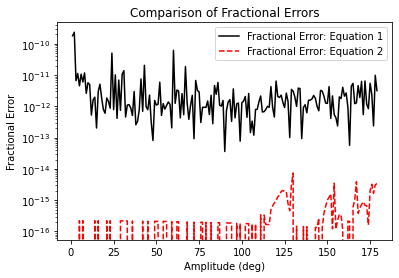

In [13]:
ellipans= (2/np.pi)*sf.ellipk(np.sin(theta_m/2)**2)
eq1_fracerr= np.abs(ellipans- eq1ans)/ ellipans
eq2_fracerr= np.abs(ellipans- eq2ans)/ ellipans

plt.semilogy(np.degrees(theta_m), eq1_fracerr, 'k', label='Fractional Error: Equation 1')
plt.semilogy(np.degrees(theta_m), eq2_fracerr, 'r--', label= 'Fractional Error: Equation 2')
plt.xlabel('Amplitude (deg)')
plt.ylabel('Fractional Error')
plt.title('Comparison of Fractional Errors')
plt.legend()

The error from the integral in Eq. $(\ref{eq:period2})$ should look strange.  You may be worried that is incorrect.  Explain the source of the strange behavior of this error curve.  (*Hint:* Look at the actual values of the errors, not just as they show up in the plot.)

For equation 2, there are some theta_m values that produce results that have so small an error, or no error that Python would not find a fractional error between the analytical and numerical result. This causes the oscillation between fractional error values of zero and very small fractional errors. 

### Series Formula

Returning to the series form in $(\ref{eq:periodsum})$ it is not surprising that it does a poor job at large amplitude, particularly since we truncate the sum after a few terms, at $a_8$.  Explain why this is the case.

Since the sum is a truncated Taylor series, once we get far enough away from the point we expanded about, the series becomes worse at estimating values. At large amplitudes we get too far away from our expansion point to be able to estimate the period. 

For what amplitude, $\theta_m$, from the grid used above, does the fractional error in the period calculated using the series form $(\ref{eq:periodsum})$ become larger than $10^{-10}$?  (*Note:* The clever way to do this is to use the `where` function, though we have not discussed the `where` function yet so is not necessary to use it here here. Instead, you can just look through the list of values and find the relevant one.  We will learn about the `where` function in the near future.  Also note that we want the **value of the amplitude, $\theta_m$**, not the index number of where this occurs in the array you calculated.)

In [14]:
eq3_fracerr= np.abs(ellipans- eq3ans)/ ellipans

print("The fractional error for the series form becomes greater than 10^-10 when theta_m=16 degrees.")

The fractional error for the series form becomes greater than 10^-10 when theta_m=16 degrees.


## Analytic Manipulations

You may wonder why we bothered to have two different integral forms for the period, $(\ref{eq:period1})$ and $(\ref{eq:period2})$.  Since `quad` can handle divergent integrands it can, and does, give us good answers to the integral in Eq. $(\ref{eq:period1})$, so why bother doing the analytic work to transform the integral?  We found above that the transformed integral $(\ref{eq:period2})$ did lead to smaller errors, so that is a benefit.  Even more so, the transformed integral requires far less work to compute.  Thus by doing a small mathematical manipulation (as you have done in the homework) we arrive at a much easier and much more accurate formula for the computer to evaluate.

To verify this, calculate the period for $\theta_m=97^\circ$ using $(\ref{eq:period1})$ and $(\ref{eq:period2})$.  Print the fractional errors and number of function evaluations required for each integral.  Be amazed!

In [15]:
(eq1res, eq1err, eq1info)= integ.quad(eq1, 0, np.radians(97), args=(np.radians(97)), full_output=True)
eq1res= (np.sqrt(2)/np.pi)* eq1res

(eq2res, eq2err, eq2info)= integ.quad(eq2, 0, np.pi/2, args=(np.radians(97)), full_output=True)
eq2res= (2/np.pi) * eq2res

ellipans97= (2/np.pi)*sf.ellipk(np.sin(np.radians(97)/2)**2) 

print("Fractional Error for Eq 1:", np.abs(ellipans97- eq1res)/ ellipans97)
print("Fractional Error for Eq 2:", np.abs(ellipans97- eq2res)/ ellipans97)

print("Function Evaluations for Eq 1:", eq1info['neval'])
print("Function Evaluations for Eq 2:", eq2info['neval'])

Fractional Error for Eq 1: 1.2170815759130747e-12
Fractional Error for Eq 2: 1.8266270087244106e-16
Function Evaluations for Eq 1: 315
Function Evaluations for Eq 2: 21


## Member Participation

See Lab00 for instructions on turning in labs.  We will follow this procedure the entire semester.

In the following cell enter the *Case ID* for each student in the group who partcipated in this lab.  Again, see Lab00 for more details.  It is expected that you have read and understood those details.

gmm102, rnj13, zxw721